In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.patches import Patch
from pylab import *

import plotnine
from plotnine import *

dpi = 300

In [2]:
micro_colour_dict = {
    "1a": "#FF8B82",
    "1b": "#FF8B82", 
    "2": "#009E92", 
    "3": "#4CB9FF", 
    "4": "#F7B200", 
    "5": "#FF81BE", 
    "1": "#FF8B82", 
    "x":"#878787",
    " ":"#878787"
}

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math


def computeSigmoid(xmax, xmin, ymax, ymin, points = 50):
    x = np.linspace(-10, 10, points)
    z = 1/(1 + np.exp(-x))

    x = [((c-min(x))/(max(x)-min(x))) * (xmax-xmin) + xmin for c in x]
    z = [((c-min(z))/(max(z)-min(z))) * (ymax-ymin) + ymin for c in z[::-1] ]
    
    return x, z

def generateRectBoxDF(all_candidates_ordered, start_candidates, stop_candidates, w1, w2, niche_labels, sep_niche = True, vertical = False, offset = False):
    if sep_niche:
        all_candidates_ordered = np.insert(all_candidates_ordered, [int(np.where(all_candidates_ordered == cell)[0] + 1) for cell in stop_candidates], " ") 
    
    df_box = pd.DataFrame({
        "x2": np.array([np.where(all_candidates_ordered == c) for c in start_candidates]).flatten(),
        "x1": np.array([np.where(all_candidates_ordered == c) for c in stop_candidates]).flatten(),
        "y1": np.repeat(w1, len(start_candidates) ),
        "y2": np.repeat(w2, len(stop_candidates) ), 
        "niche": niche_labels
    })
    
    if sep_niche:
        df_box["x1"] = df_box["x1"] + 1

    if offset:
        df_box["x1_offset"] = range(len(df_box))[::-1]
        df_box["x2_offset"] = range(1,len(df_box)+1)[::-1]
        df_box["x_text"] = (df_box.x1 + df_box["x1_offset"])+( (df_box.x2+df_box["x2_offset"]) - (df_box.x1+df_box["x1_offset"]) )/2    
    else:
        df_box["x_text"] = df_box.x1+(df_box.x2 - df_box.x1)/2
        
    df_box["y_text"] = df_box.y1+(df_box.y2 - df_box.y1)/2
    
    if vertical:
        if offset:
            df_box = df_box.set_axis(["y2", "y1", "x1", "x2", "niche", "y1_adj", "y2_adj", "y_text", "x_text"], axis=1, inplace=False)
        else:
            df_box = df_box.set_axis(["y2", "y1", "x1", "x2", "niche", "y_text", "x_text"], axis=1, inplace=False)
    
    return df_box, all_candidates_ordered


def sankeyPlotsLineDF(start_candidates_order, stop_candidates_order, candidates, x1, x2, df_abs_start = None, df_abs_stop = None, offset_df_start = None, offset_df_stop = None):
    cell_lines = pd.DataFrame()
    start_dendro_dict = pd.DataFrame(index = start_candidates_order, data = range(len(start_candidates_order))).to_dict()[0]
    stop_dendro_dict = pd.DataFrame(index = stop_candidates_order, data = range(len(stop_candidates_order))).to_dict()[0]
    for c in candidates:
        get_y = [start_dendro_dict.get(c),  stop_dendro_dict.get(c)]
        print(get_y)
        if None not in get_y:
            if any(offset_df_start is not None and offset_df_stop is not None):
                get_y[0] = get_y[0] + offset_df_start[[offset_df_start.iloc[c].y2 >= get_y[0] and offset_df_start.iloc[c].y1 <= get_y[0] for c in range(len(offset_df_start))]]["y1_adj"].values[0]
                get_y[1] = get_y[1] + offset_df_stop[[offset_df_stop.iloc[c].y2 >= get_y[1] and offset_df_stop.iloc[c].y1 <= get_y[1] for c in range(len(offset_df_stop))]]["y1_adj"].values[0]
            
            print(get_y)
            x, z = computeSigmoid(x2, x1, ymax = get_y[0], ymin = get_y[1])
            
            if df_abs_stop is not None:
                if df_abs_start is not None:
                    start_abs = np.array(df_abs_start.abundance.values[np.where(df_abs_start.Celltype == c)]).flatten()
                    stop_abs = np.array(df_abs_stop.abundance.values[np.where(df_abs_stop.Celltype == c)]).flatten()
                    z_step = abs(start_abs - stop_abs)/len(z)
                    if start_abs < stop_abs:
                        z_abs = np.array([start_abs] + [start_abs + z_n*z_step for z_n in range(1, len(z)-1)] + [stop_abs]).flatten()
                    else:
                        z_abs = np.array([start_abs] + [start_abs - z_n*z_step for z_n in range(1, len(z)-1)] + [stop_abs]).flatten()

                    cell_lines = cell_lines.append(pd.DataFrame({
                        "y" : z, 
                        "x" : x,
                        "cell_state" : c,
                        "abs" : z + z_abs
                    }))
                else:
                    cell_lines = cell_lines.append(pd.DataFrame({
                        "y" : z, 
                        "x" : x,
                        "cell_state" : c,
                        "abs" : z + np.array(df_abs_stop.abundance.values[np.where(df_abs_stop.Celltype == c)]).flatten()
                    }))
            
            else:
                cell_lines = cell_lines.append(pd.DataFrame({
                    "y" : z, 
                    "x" : x,
                    "cell_state" : c
                }))
       
    return cell_lines

def nmfDotPlot(df_dots, df_niches, colour_handles, x_dendro, y_dendro):
    g =(
        ggplot() +
        geom_point(data = df_dots, mapping = aes( x = "Cellstate", y = "factor", fill = "norm_abundance", size = "value" ), colour = "white") +
        geom_rect(data = df_niches, mapping = aes(xmin="x1", xmax="x2", ymin="y1", ymax="y2"), fill = colour_handles ) +
        geom_text(data = df_niches, mapping = aes(x="x_text", y="y_text", label="niche"), colour = "white", size=20) +
        theme_bw() +
        theme(axis_text_x = element_text(angle = 60, vjust = 1, hjust=1, size=20),
              axis_text_y = element_text(size=20),
              axis_title_x = element_text(size=36), 
              axis_title_y = element_text(size=36),
              axis_ticks_major_x = element_blank(),
              panel_grid_major_x = element_blank(),
              panel_grid_major_y = element_blank(),
    #           strip_background_x= element_blank(),
    #           strip_text_x = element_text(size = 20),
              panel_border = element_blank(),
              panel_spacing_x = .5,
              panel_spacing_y = .2,
              legend_position = "right" , 
              legend_key_height=40, 
              legend_title = element_text(size = 20),
              legend_text = element_text(size = 20) ) +
        scale_size_continuous(range=[0,15], guide=False) + 
        scale_fill_distiller(palette = "RdPu", direction = 1, limits = [-1,1], name = "Z-score\nCell abundance\n\n") +
        scale_x_discrete(limits = x_dendro ) +
        scale_y_discrete(limits = y_dendro)
    
    )
    return g

def cmapHexCode(name, lut):
    return [mpl.colors.rgb2hex(cm.get_cmap(name = name, lut = lut)(c)) for c in range(lut) ]

In [4]:
from imp import load_source
nanospot=load_source('nanospot', '/home/jovyan/python/Nanospot/nanospot/nanospot.py')

In [5]:
df_dotplot = pd.read_csv("../data/fig5_pathology_case300_Z-scoreCelltypeAbundance_PercentageROI_4pathologies.csv", sep = ",", index_col = 0)

In [6]:
nmf_pres = pd.read_csv("../data/fig5_nmf_PRES-500-nfact10.csv", sep = ",", index_col = 0)
nmf_pres.factor = nmf_pres.factor.astype("str")

In [7]:
norm_abs_pres=[]
for indx in range(len(nmf_pres)):
    if nmf_pres.iloc[indx].value != 0:
        norm_abs_pres.append(df_dotplot[ [ df_dotplot.iloc[c].Background == "PRES" and df_dotplot.iloc[c].Celltype == nmf_pres.iloc[indx].Cellstate for c in range(len(df_dotplot)) ] ].value.values[0])
    else:
        norm_abs_pres.append(0)
        
nmf_pres["norm_abundance"] = norm_abs_pres

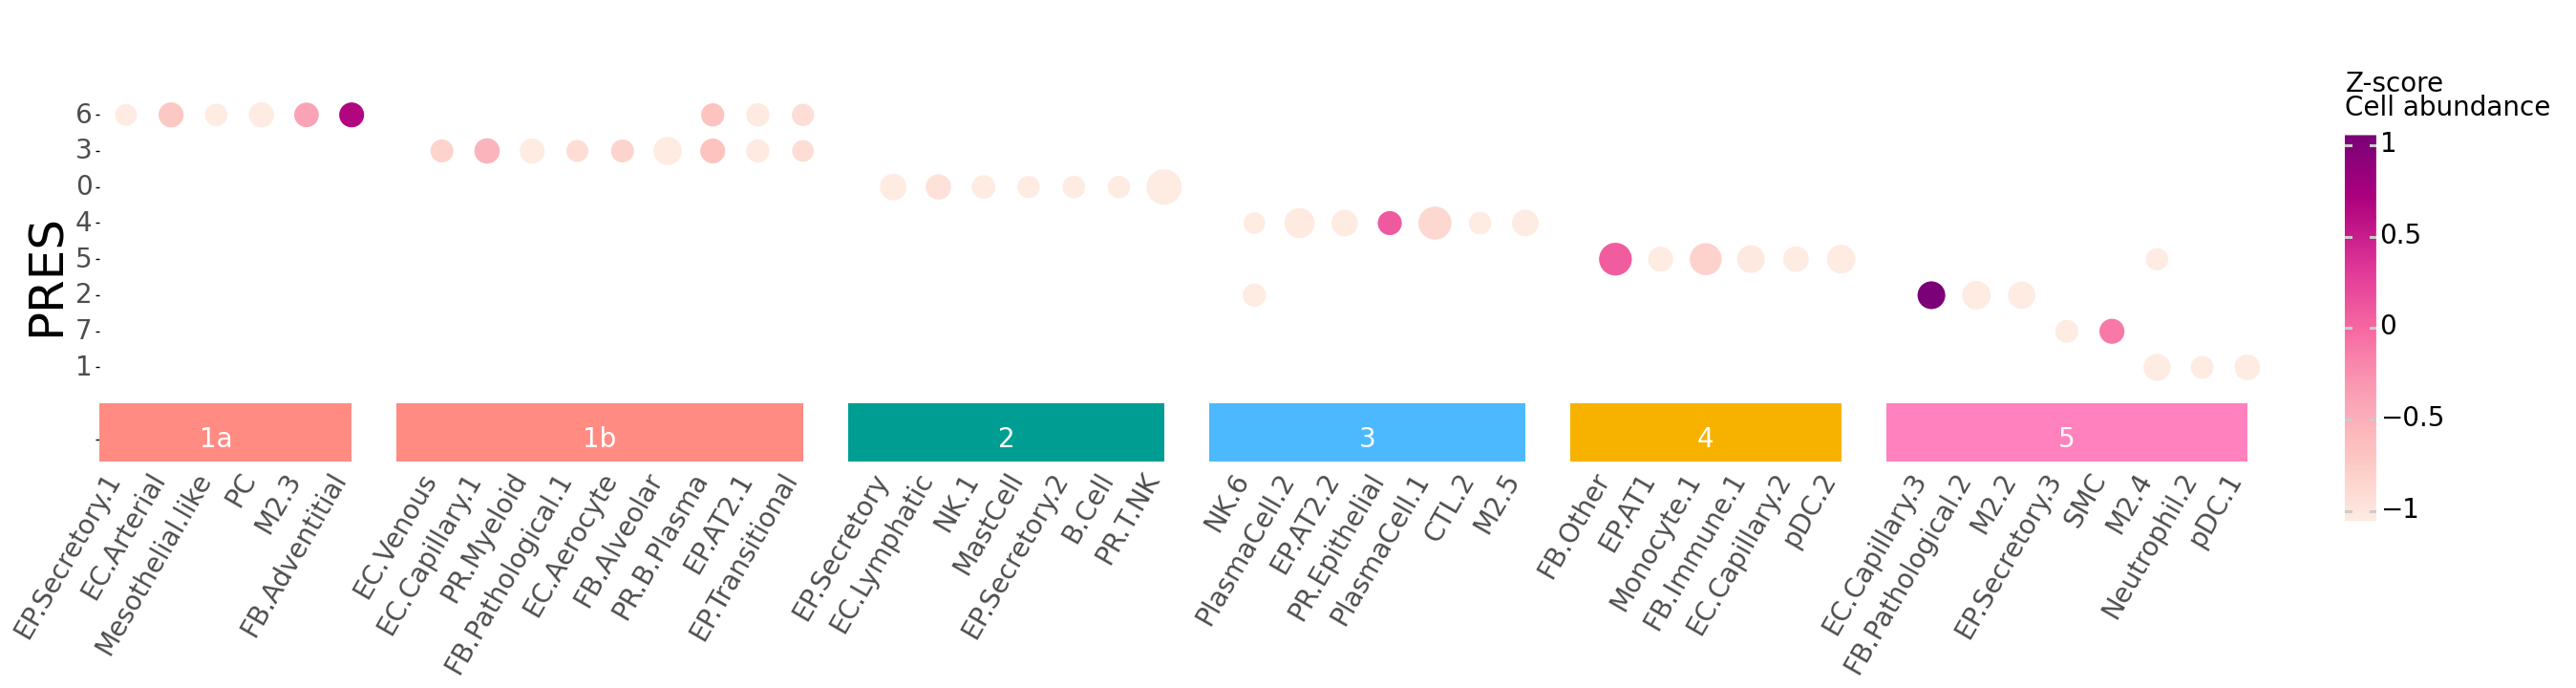

<ggplot: (8785437773520)>

In [8]:
plotnine.options.figure_size=(30,5)
plotnine.dpi = dpi

pres_box, new_order_1 = generateRectBoxDF(
    nmf_pres.Cellstate.unique()[nmf_pres.cell_state_dendrogram.unique()], 
    start_candidates = ["EP.Secretory.1", "EC.Venous", "EP.Secretory", "NK.6", "FB.Other", "EC.Capillary.3"],
    stop_candidates = ["FB.Adventitial", "EP.Transitional", "PR.T.NK", "M2.5", "pDC.2", "pDC.1"],
    w1 = 0,
    w2 = 2,
    niche_labels = ["1a", "1b", "2", "3", "4", "5"],
    sep_niche = True
)

p1 = nmfDotPlot(
    df_dots = nmf_pres,
    df_niches = pres_box,
    colour_handles = [micro_colour_dict.get(micro) for micro in pres_box.niche],
    x_dendro = new_order_1,
    y_dendro = ["6","3","0","4","5","2","7","1","", ""][::-1]
) + ylab("PRES") + xlab("")

p1 

In [9]:
nmf_edad = pd.read_csv("../data/fig5_nmf_EDAD-500-nfact9.csv", sep = ",", index_col = 0)
nmf_edad.factor = nmf_edad.factor.astype("str")

In [10]:
norm_abs_edad=[]
for indx in range(len(nmf_edad)):
    if nmf_edad.iloc[indx].value != 0:
        norm_abs_edad.append(df_dotplot[ [ df_dotplot.iloc[c].Background == "EDAD" and df_dotplot.iloc[c].Celltype == nmf_edad.iloc[indx].Cellstate for c in range(len(df_dotplot)) ] ].value.values[0])
    else:
        norm_abs_edad.append(0)
        
nmf_edad["norm_abundance"] = norm_abs_edad

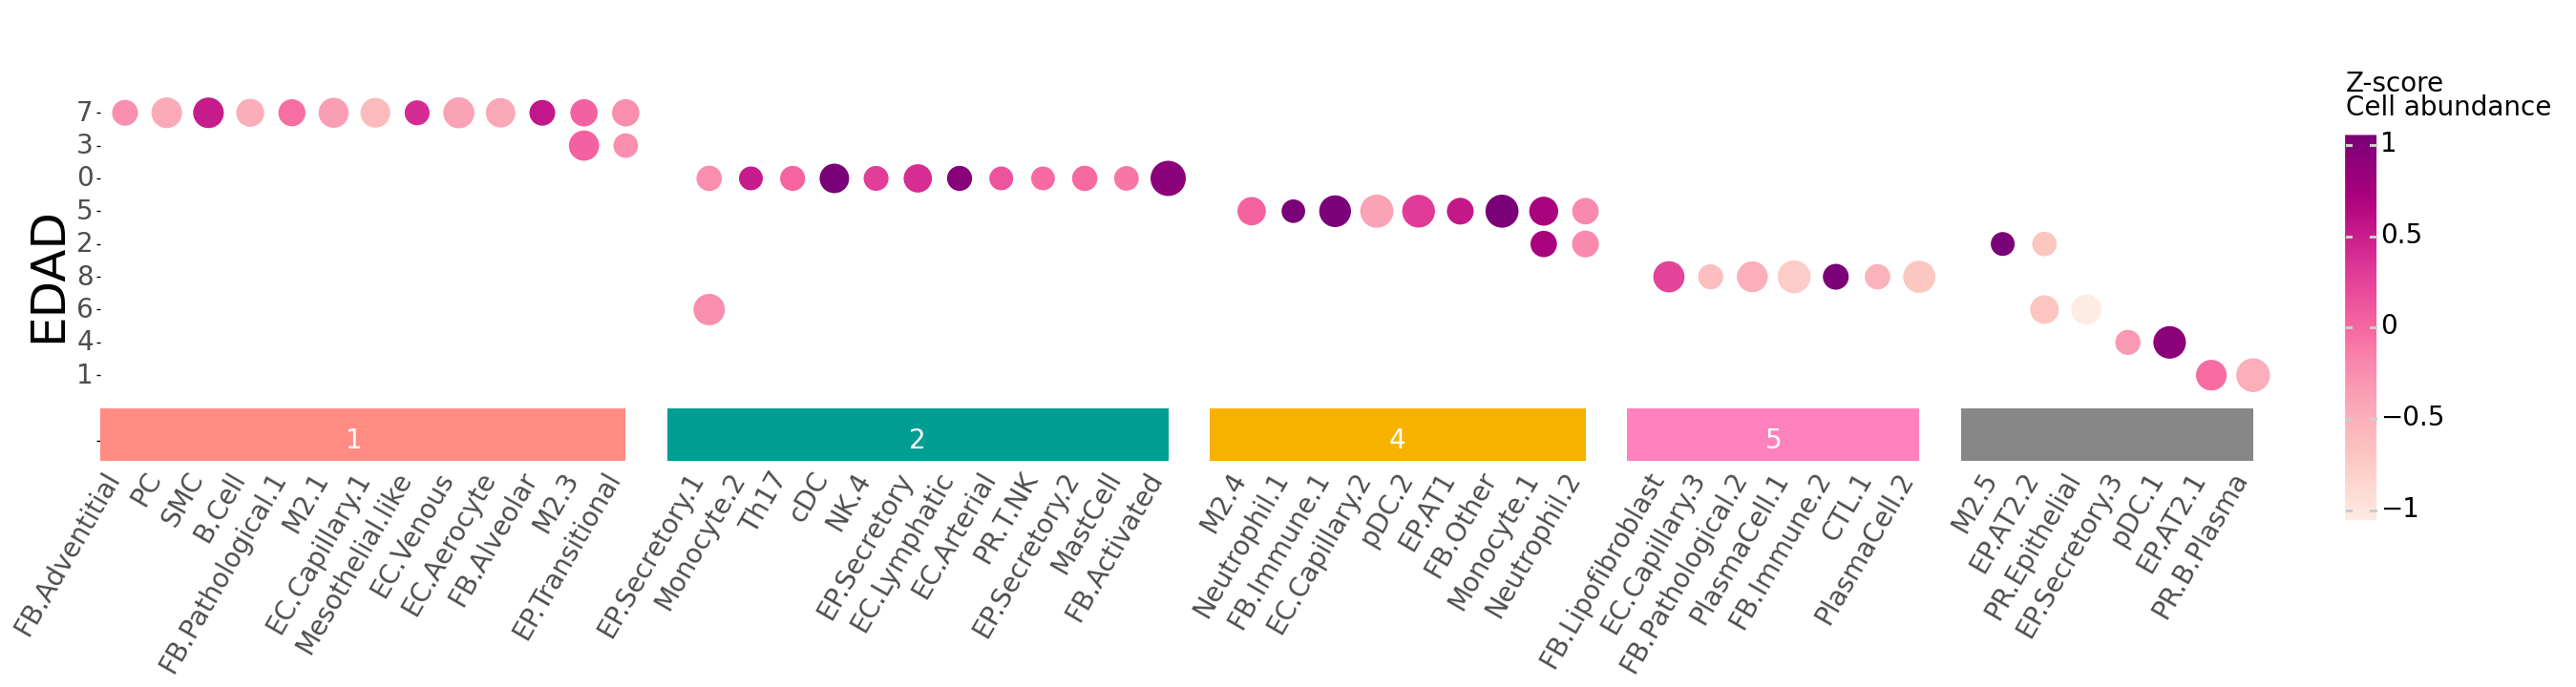

<ggplot: (8785429237194)>

In [11]:
plotnine.options.figure_size=(30,5)
plotnine.dpi = dpi


edad_box, new_order_2 = generateRectBoxDF(
    nmf_edad.Cellstate.unique()[nmf_edad.cell_state_dendrogram.unique()], 
    start_candidates = ["FB.Adventitial", "EP.Secretory.1", "M2.4", "FB.Lipofibroblast", "M2.5"],
    stop_candidates = ["EP.Transitional", "FB.Activated", "Neutrophil.2", "PlasmaCell.2", "PR.B.Plasma"],
    w1 = 0,
    w2 = 2,
    niche_labels = ["1", "2", "4", "5", " "],
    sep_niche = True
)

p2 = nmfDotPlot(
    df_dots = nmf_edad,
    df_niches = edad_box,
    colour_handles = [micro_colour_dict.get(micro) for micro in edad_box.niche],
    x_dendro = new_order_2,
    y_dendro = ["7","3","0","5","2","8","6","4","1","", ""][::-1]
) + ylab("EDAD") + xlab("")

p2

In [12]:
nmf_mdad = pd.read_csv("../data/fig5_nmf_MDAD-500-nfact8.csv", sep = ",", index_col = 0)
nmf_mdad.factor = nmf_mdad.factor.astype("str")

In [13]:
norm_abs_mdad=[]
for indx in range(len(nmf_mdad)):
    if nmf_mdad.iloc[indx].value != 0:
        norm_abs_mdad.append(df_dotplot[ [ df_dotplot.iloc[c].Background == "MDAD" and df_dotplot.iloc[c].Celltype == nmf_mdad.iloc[indx].Cellstate for c in range(len(df_dotplot)) ] ].value.values[0])
    else:
        norm_abs_mdad.append(0)
        
nmf_mdad["norm_abundance"] = norm_abs_mdad

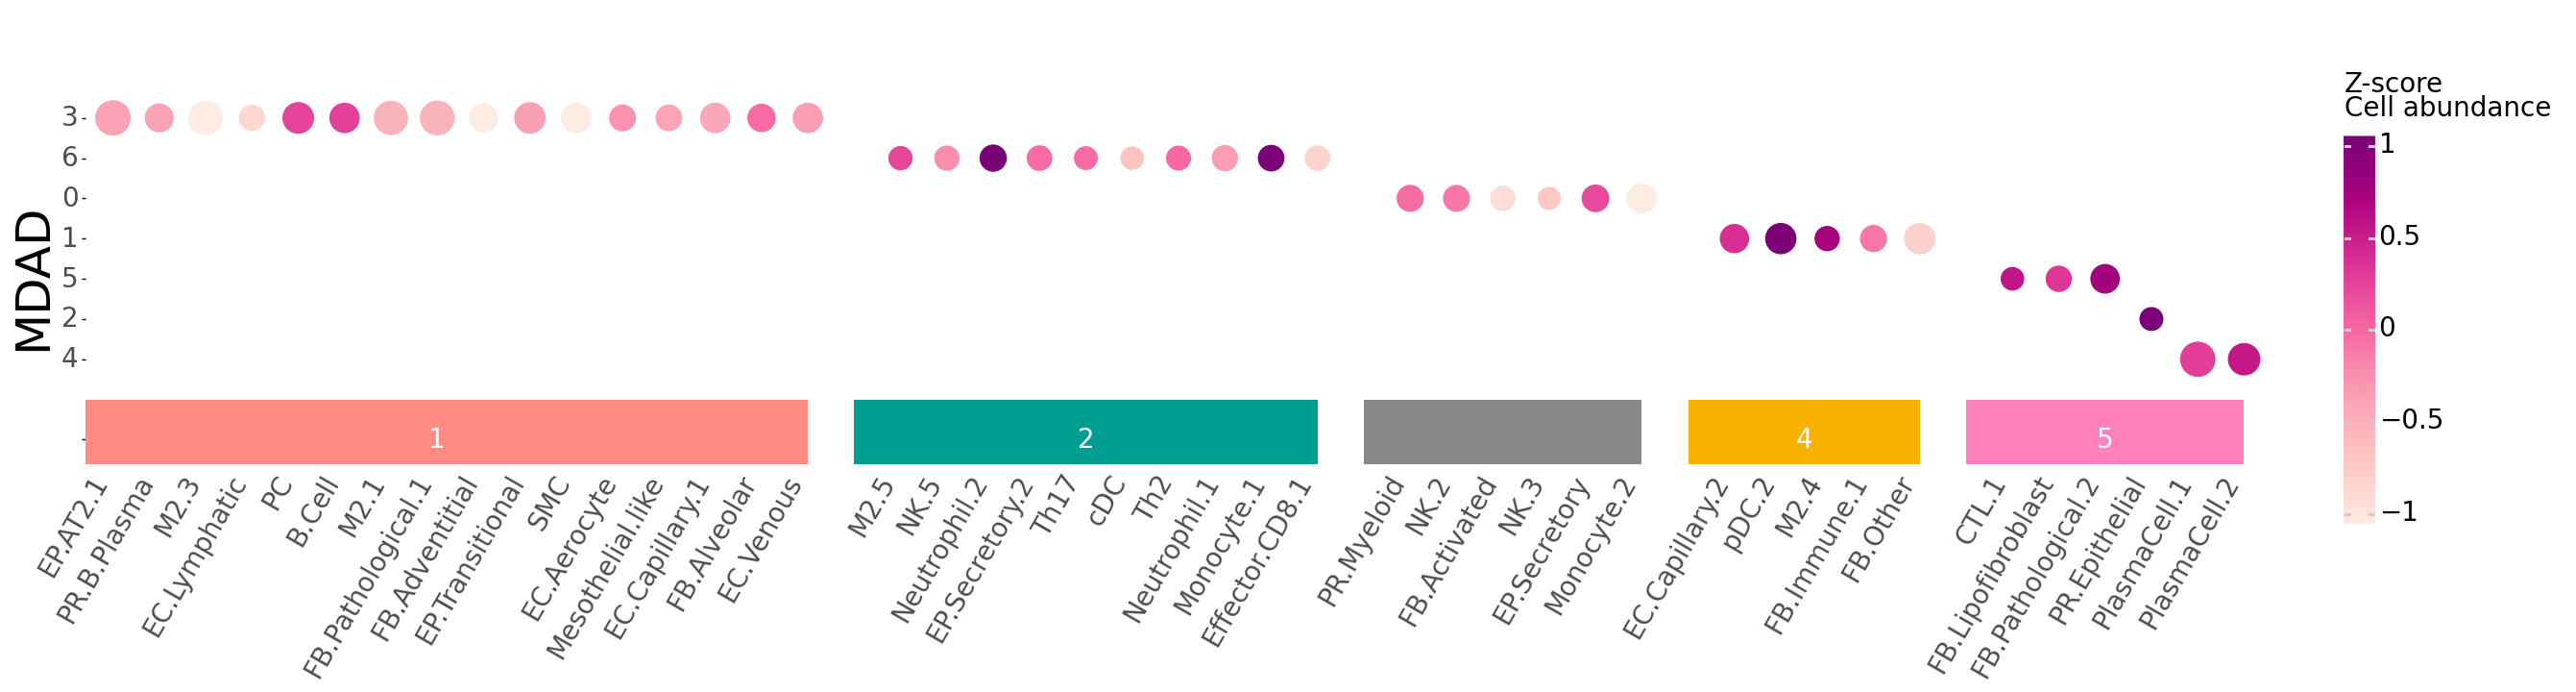

<ggplot: (8785429133834)>

In [14]:
plotnine.options.figure_size=(30,5)
plotnine.dpi = dpi

mdad_box, new_order_3 = generateRectBoxDF(
    nmf_mdad.Cellstate.unique()[nmf_mdad.cell_state_dendrogram.unique()], 
    start_candidates = ["EP.AT2.1", "M2.5", "PR.Myeloid", "EC.Capillary.2", "CTL.1"],
    stop_candidates = ["EC.Venous", "Effector.CD8.1", "Monocyte.2", "FB.Other", "PlasmaCell.2"],
    w1 = 0,
    w2 = 2,
    niche_labels = ["1", "2"," ", "4", "5"],
    sep_niche = True
)

p3 = nmfDotPlot(
    df_dots = nmf_mdad,
    df_niches = mdad_box,
    colour_handles = [micro_colour_dict.get(micro) for micro in mdad_box.niche],
    x_dendro = new_order_3,
    y_dendro = ["3","6","0","1","5","2","4","", ""][::-1]
) + ylab("MDAD") + xlab("")

p3

In [15]:
nmf_odad = pd.read_csv("../data/fig5_nmf_ODAD-500-nfact11.csv", sep = ",", index_col = 0)
nmf_odad.factor = nmf_odad.factor.astype("str")

In [16]:
norm_abs_odad=[]
for indx in range(len(nmf_odad)):
    if nmf_odad.iloc[indx].value != 0:
        norm_abs_odad.append(df_dotplot[ [ df_dotplot.iloc[c].Background == "ODAD" and df_dotplot.iloc[c].Celltype == nmf_odad.iloc[indx].Cellstate for c in range(len(df_dotplot)) ] ].value.values[0])
    else:
        norm_abs_odad.append(0)
        
nmf_odad["norm_abundance"] = norm_abs_odad

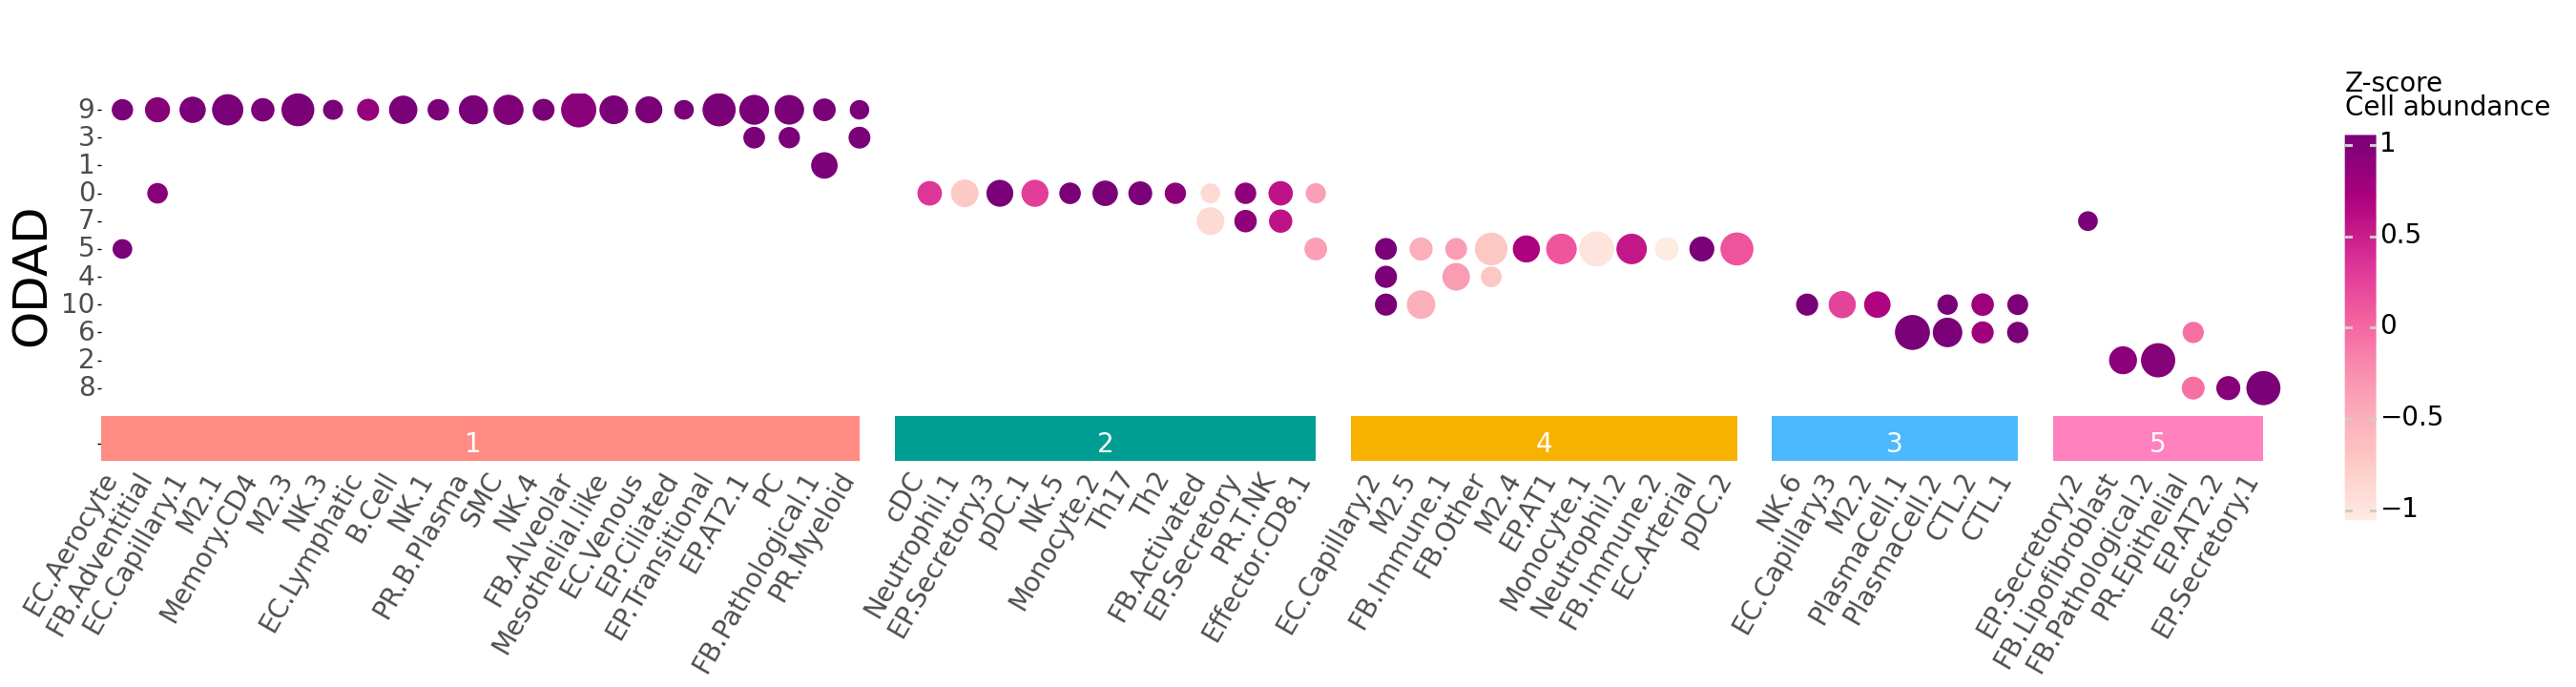

<ggplot: (8785429047420)>

In [17]:
plotnine.options.figure_size=(30,5)
plotnine.dpi = dpi

odad_box, new_order_4 = generateRectBoxDF(
    nmf_odad.Cellstate.unique()[nmf_odad.cell_state_dendrogram.unique()], 
    start_candidates = ["EC.Aerocyte", "cDC", "EC.Capillary.2", "NK.6", "EP.Secretory.2"],
    stop_candidates = ["PR.Myeloid", "Effector.CD8.1", "pDC.2", "CTL.1", "EP.Secretory.1"],
    w1 = 0,
    w2 = 2,
    niche_labels = ["1", "2","4", "3", "5"],
    sep_niche = True
)

p4 = nmfDotPlot(
    df_dots = nmf_odad,
    df_niches = odad_box,
    colour_handles = [micro_colour_dict.get(micro) for micro in odad_box.niche],
    x_dendro = new_order_4,
    y_dendro = ["9","3","1","0","7","5","4","10","6","2","8","", ""][::-1]
) + ylab("ODAD") + xlab("")

p4

In [18]:
%%capture
plotnine.options.figure_size=(7,10)
plotnine.dpi = dpi

candidate_cell_states = ["FB.Pathological.1","FB.Pathological.2", 
                         "PlasmaCell.1", "PlasmaCell.2", "CTL.1", "CTL.2", 
                         "EP.AT2.2", "EP.Transitional", "EC.Capillary.1", "EC.Capillary.2", "EC.Venous", "EC.Lymphatic", 
                         "NK.6", "M2.2", "M2.5"]

# shift abundances baseline
baselined = df_dotplot['value'] + abs(np.min(df_dotplot['value']))
df_dotplot['abundance'] = baselined/np.max(baselined)

pres_box, new_order_1 = generateRectBoxDF(
    nmf_pres.Cellstate.unique()[nmf_pres.cell_state_dendrogram.unique()][::-1], 
    start_candidates = ["EP.Secretory.1", "EC.Venous", "EP.Secretory", "NK.6", "FB.Other", "EC.Capillary.3"],
    stop_candidates = ["FB.Adventitial", "EP.Transitional", "PR.T.NK", "M2.5", "pDC.2", "pDC.1"],
    w1 = 0,
    w2 = .5,
    niche_labels = ["1a", "1b", "2", "3", "4", "5"],
    sep_niche = False, vertical = True, offset = True
)

edad_box, new_order_2 = generateRectBoxDF(
    nmf_edad.Cellstate.unique()[nmf_edad.cell_state_dendrogram.unique()][::-1], 
    start_candidates = ["FB.Adventitial", "EP.Secretory.1", "M2.4", "FB.Lipofibroblast", "M2.5"],
    stop_candidates = ["EP.Transitional", "FB.Activated", "Neutrophil.2", "PlasmaCell.2", "PR.B.Plasma"],
    w1 = 3,
    w2 = 3.5,
    niche_labels = ["1", "2", "4", "5", "x"],
    sep_niche = False, vertical = True, offset = True
)

mdad_box, new_order_3 = generateRectBoxDF(
    nmf_mdad.Cellstate.unique()[nmf_mdad.cell_state_dendrogram.unique()][::-1], 
    start_candidates = ["EP.AT2.1", "M2.5", "PR.Myeloid", "EC.Capillary.2", "CTL.1"],
    stop_candidates = ["EC.Venous", "Effector.CD8.1", "Monocyte.2", "FB.Other", "PlasmaCell.2"],
    w1 = 6,
    w2 = 6.5,
    niche_labels = ["1", "2","x", "4", "5"],
    sep_niche = False, vertical = True, offset = True
)

odad_box, new_order_4 = generateRectBoxDF(
    nmf_odad.Cellstate.unique()[nmf_odad.cell_state_dendrogram.unique()][::-1], 
    start_candidates = ["EC.Aerocyte", "cDC", "EC.Capillary.2", "NK.6", "EP.Secretory.2"],
    stop_candidates = ["PR.Myeloid", "Effector.CD8.1", "pDC.2", "CTL.1", "EP.Secretory.1"],
    w1 = 9,
    w2 = 9.5,
    niche_labels = ["1", "2","4", "3", "5"],
    sep_niche = False, vertical = True, offset = True
)


cell_lines_pres2edad = sankeyPlotsLineDF(
    start_candidates_order = new_order_1,
    stop_candidates_order = new_order_2,
    candidates = candidate_cell_states,
    x1 = .5,
    x2 = 3, 
    df_abs_start = df_dotplot[[df_dotplot.iloc[c].Background == "PRES" for c in range(len(df_dotplot))]],
    df_abs_stop = df_dotplot[[df_dotplot.iloc[c].Background == "EDAD" for c in range(len(df_dotplot))]], 
    offset_df_start = pres_box,
    offset_df_stop = edad_box
)


cell_lines_edad2mdad = sankeyPlotsLineDF(
    start_candidates_order = new_order_2,
    stop_candidates_order = new_order_3,
    candidates = candidate_cell_states,
    x1 = 3.5,
    x2 = 6, 
    df_abs_start = df_dotplot[[df_dotplot.iloc[c].Background == "EDAD" for c in range(len(df_dotplot))]],
    df_abs_stop = df_dotplot[[df_dotplot.iloc[c].Background == "MDAD" for c in range(len(df_dotplot))]], 
    offset_df_start = edad_box,
    offset_df_stop = mdad_box
)

cell_lines_mdad2odad = sankeyPlotsLineDF(
    start_candidates_order = new_order_3,
    stop_candidates_order = new_order_4,
    candidates=candidate_cell_states,
    x1 = 6.5,
    x2 = 9, 
    df_abs_start = df_dotplot[[df_dotplot.iloc[c].Background == "MDAD" for c in range(len(df_dotplot))]],
    df_abs_stop = df_dotplot[[df_dotplot.iloc[c].Background == "ODAD" for c in range(len(df_dotplot))]], 
    offset_df_start = mdad_box,
    offset_df_stop = odad_box
)

all_pres2odad=sankeyPlotsLineDF(
    start_candidates_order = new_order_1,
    stop_candidates_order = new_order_2,
    candidates=pd.concat([nmf_pres, nmf_edad]).Cellstate.unique(),
    x1 = .5,
    x2 = 3, 
    df_abs_start = df_dotplot[[df_dotplot.iloc[c].Background == "PRES" for c in range(len(df_dotplot))]],
    df_abs_stop = df_dotplot[[df_dotplot.iloc[c].Background == "EDAD" for c in range(len(df_dotplot))]], 
    offset_df_start = pres_box,
    offset_df_stop = edad_box
)

all_pres2odad= all_pres2odad.append(sankeyPlotsLineDF(
    start_candidates_order = new_order_2,
    stop_candidates_order = new_order_3,
    candidates=pd.concat([nmf_edad, nmf_mdad]).Cellstate.unique(),
    x1 = 3.5,
    x2 = 6, 
    df_abs_start = df_dotplot[[df_dotplot.iloc[c].Background == "EDAD" for c in range(len(df_dotplot))]],
    df_abs_stop = df_dotplot[[df_dotplot.iloc[c].Background == "MDAD" for c in range(len(df_dotplot))]], 
    offset_df_start = edad_box,
    offset_df_stop = mdad_box
))


all_pres2odad= all_pres2odad.append(sankeyPlotsLineDF(
    start_candidates_order = new_order_3,
    stop_candidates_order = new_order_4,
    candidates=pd.concat([nmf_mdad, nmf_odad]).Cellstate.unique(),
    x1 = 6.5,
    x2 = 9, 
    df_abs_start = df_dotplot[[df_dotplot.iloc[c].Background == "MDAD" for c in range(len(df_dotplot))]],
    df_abs_stop = df_dotplot[[df_dotplot.iloc[c].Background == "ODAD" for c in range(len(df_dotplot))]], 
    offset_df_start = mdad_box,
    offset_df_stop = odad_box
))

df_axis_text_x = pd.DataFrame({
    "x" : [0.25, 3.25, 6.25, 9.25],
    "y" : -2,
    "labels" : ["PRES", "EDAD", "MDAD", "ODAD"]
})

alpha = .8
bg_alpha = .1
bg_size = .5
rect_font_size = 16


In [19]:
plotnine.options.figure_size=(8,12)
plotnine.dpi = dpi



p5 = (
    ggplot() +
#     geom_line(data = all_pres2odad, mapping = aes(x = "x", y = "y", group = "cell_state",), alpha = bg_alpha, size = bg_size) +
    geom_ribbon(data = all_pres2odad, mapping = aes(x = "x", ymax = "abs", ymin = "y", group = "cell_state",), alpha = bg_alpha, size = bg_size) +
    geom_rect(data = pres_box, mapping = aes(xmin="x1", xmax="x2", ymin="y1+y1_adj", ymax="y2+y2_adj"), fill = [micro_colour_dict.get(micro) for micro in ["1a", "1b", "2", "3", "4", "5"]]) +
    geom_text(data = pres_box, mapping = aes(x="x_text", y="y_text", label="niche"), size=rect_font_size, colour = "white") +
    geom_rect(data = edad_box, mapping = aes(xmin="x1", xmax="x2", ymin="y1+y1_adj", ymax="y2+y2_adj"), fill = [micro_colour_dict.get(micro) for micro in ["1", "2",  "4", "5", "x"]]) +
    geom_text(data = edad_box, mapping = aes(x="x_text", y="y_text", label="niche"), size=rect_font_size, colour = "white") +
    geom_rect(data = mdad_box, mapping = aes(xmin="x1", xmax="x2", ymin="y1+y1_adj", ymax="y2+y2_adj"), fill = [micro_colour_dict.get(micro) for micro in ["1", "2",  "x", "4", "5"]]) +
    geom_text(data = mdad_box, mapping = aes(x="x_text", y="y_text", label="niche"), size=rect_font_size, colour = "white") +
    geom_rect(data = odad_box, mapping = aes(xmin="x1", xmax="x2", ymin="y1+y1_adj", ymax="y2+y2_adj"), fill = [micro_colour_dict.get(micro) for micro in ["1", "2",  "4", "3", "5"]]) +
    geom_text(data = odad_box, mapping = aes(x="x_text", y="y_text", label="niche"), size=rect_font_size, colour = "white") + 
    geom_text(data = df_axis_text_x, mapping = aes(x="x", y="y", label="labels"), size=18, colour = "black") + 
    geom_ribbon(data = cell_lines_pres2edad, mapping = aes(x = "x", ymax = "abs", ymin = "y", fill = "cell_state" ), alpha = alpha) +
    geom_ribbon(data = cell_lines_edad2mdad, mapping = aes(x = "x", ymax = "abs", ymin = "y", fill = "cell_state" ), alpha = alpha) +
    geom_ribbon(data = cell_lines_mdad2odad, mapping = aes(x = "x", ymax = "abs", ymin = "y", fill = "cell_state" ), alpha = alpha) +
    theme_bw() +
    theme(axis_text_x = element_blank(), 
          axis_text_y = element_blank(),
#           axis_title_x = element_blank(), 
          axis_title_y = element_text(size = 20),
          axis_ticks_major_x = element_blank(),
          axis_ticks_major_y = element_blank(),
          panel_grid_major_x = element_blank(),
          panel_grid_major_y = element_blank(),
#           strip_background_x= element_blank(),
#           strip_text_x = element_text(size = 20),
          panel_border = element_blank(),
#           panel_spacing_x = .5,
#           panel_spacing_y = .2,
          legend_position = "bottom" , 
          legend_key_height=20, 
          legend_title = element_text(size = 18),
          legend_text = element_text(size = 12) ) +
    scale_fill_cmap_d(name = "icefire") +
    guides(fill=guide_legend(title="Cell states")) +
    labs(y = "Niche")
)

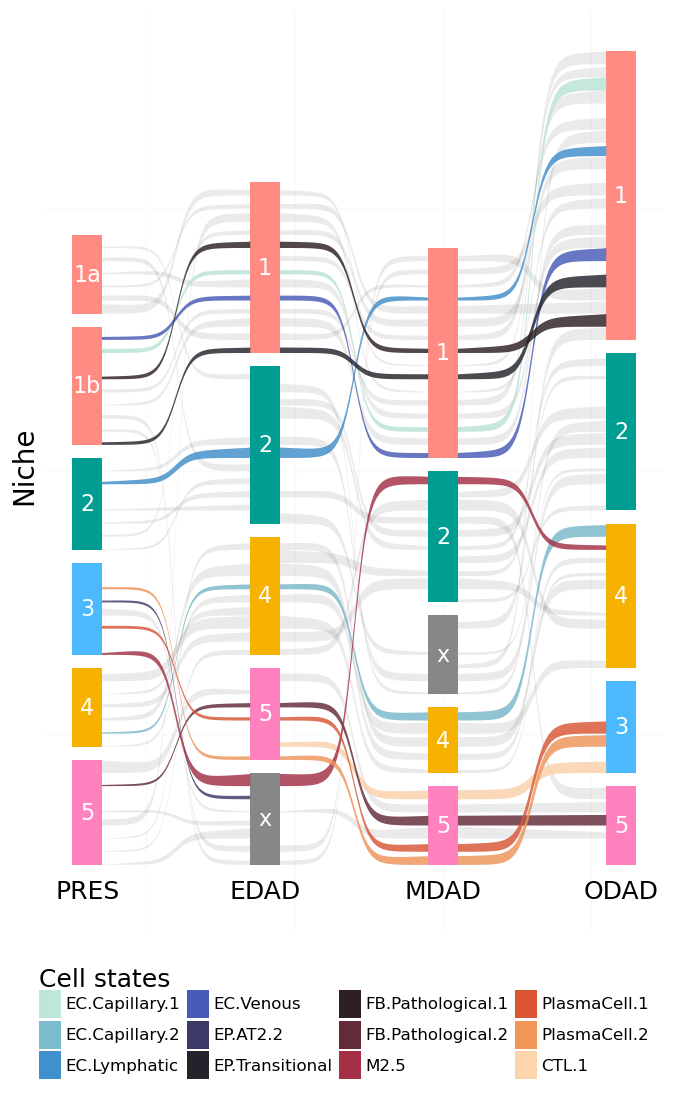

<ggplot: (8785428283402)>

In [20]:
p5

In [21]:
from upsetplot import from_contents
from upsetplot import UpSet


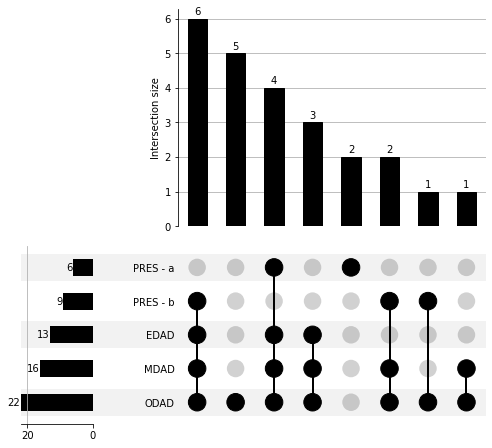

In [22]:
niche_1 = from_contents(
    {
        "PRES - a" : ['EP.Secretory.1', 'EC.Arterial', 'Mesothelial.like', 'PC', 'M2.3', 'FB.Adventitial'],
        "PRES - b" : ['EC.Venous', 'EC.Capillary.1', 'PR.Myeloid', 'FB.Pathological.1', 'EC.Aerocyte', 'FB.Alveolar', 'PR.B.Plasma', 'EP.AT2.1', 'EP.Transitional'],
        "EDAD" : ['FB.Adventitial', 'PC', 'SMC', 'B.Cell', 'FB.Pathological.1', 'M2.1', 'EC.Capillary.1', 'Mesothelial.like', 'EC.Venous', 'EC.Aerocyte', 'FB.Alveolar', 'M2.3', 'EP.Transitional'],
        "MDAD" : ['EP.AT2.1', 'PR.B.Plasma', 'M2.3', 'EC.Lymphatic', 'PC', 'B.Cell', 'M2.1', 'FB.Pathological.1', 'FB.Adventitial', 'EP.Transitional', 'SMC', 'EC.Aerocyte', 'Mesothelial.like', 'EC.Capillary.1', 'FB.Alveolar', 'EC.Venous'],
        "ODAD" : ['EC.Aerocyte', 'FB.Adventitial', 'EC.Capillary.1', 'M2.1',
           'Memory.CD4', 'M2.3', 'NK.3', 'EC.Lymphatic', 'B.Cell', 'NK.1',
           'PR.B.Plasma', 'SMC', 'NK.4', 'FB.Alveolar', 'Mesothelial.like',
           'EC.Venous', 'EP.Ciliated', 'EP.Transitional', 'EP.AT2.1', 'PC',
           'FB.Pathological.1', 'PR.Myeloid']
    }
)

plt = UpSet(niche_1, subset_size='count', show_counts='%d', sort_by="cardinality", element_size=50).plot()


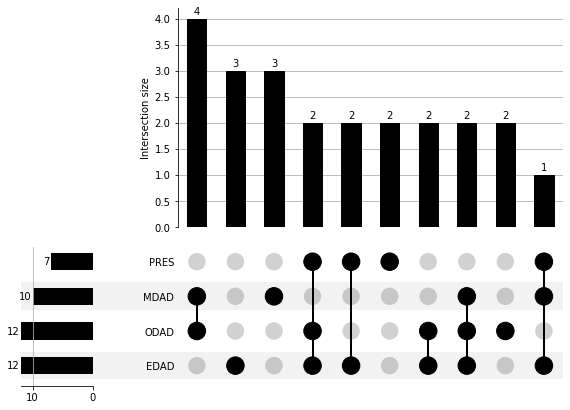

In [23]:
niche_2 = from_contents(
    {
        "PRES" : ['EP.Secretory', 'EC.Lymphatic', 'NK.1', 'MastCell', 'EP.Secretory.2', 'B.Cell', 'PR.T.NK'],
        "EDAD" : ['EP.Secretory.1', 'Monocyte.2', 'Th17', 'cDC', 'NK.4',
           'EP.Secretory', 'EC.Lymphatic', 'EC.Arterial', 'PR.T.NK',
           'EP.Secretory.2', 'MastCell', 'FB.Activated'],
        "MDAD" : ['M2.5', 'NK.5', 'Neutrophil.2',
           'EP.Secretory.2', 'Th17', 'cDC', 'Th2', 'Neutrophil.1',
           'Monocyte.1', 'Effector.CD8.1'],
        "ODAD" : ['cDC', 'Neutrophil.1',
           'EP.Secretory.3', 'pDC.1', 'NK.5', 'Monocyte.2', 'Th17', 'Th2',
           'FB.Activated', 'EP.Secretory', 'PR.T.NK', 'Effector.CD8.1']
    }
)
    


plt = UpSet(niche_2, subset_size='count', show_counts='%d', sort_by="cardinality", element_size=50).plot()
